In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from dataset import Dataset, Sample
import utils
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import time
from sklearn.metrics import accuracy_score
import seaborn as sns
sns.set_theme(style='whitegrid')

In [2]:
class PreprocessedSample(object):
    def __init__(self, sample: Sample, n=64):
        trajectory = utils.resample(sample.trajectory, n)
        trajectory = utils.scale_to_unit_square(trajectory)
        vecs = utils.vectorize(trajectory)
        
        self.trajectory = trajectory
        self.vecs = vecs
        self.gname = sample.gname

ds = Dataset.Load("../gds/training") # Load the dataset

In [3]:
# Resample, scale, translate and convert to floats
preprocessed_samples = []
for i, s in enumerate(ds.samples):
    ps = PreprocessedSample(s, 100)
    if i % 1000 == 0 and i > 0:
        print(f"processed {i} samples")
    preprocessed_samples.append(ps)

preprocessed_x = np.array([p.trajectory.flatten() for p in preprocessed_samples])
preprocessed_x = preprocessed_x.astype(np.float32)
print(preprocessed_x.shape)

processed 1000 samples
processed 2000 samples
processed 3000 samples
processed 4000 samples
(4800, 200)


In [4]:
# Encode labels
preprocessed_y = [p.gname for p in preprocessed_samples]
preprocessed_y = np.array(preprocessed_y).reshape(-1, 1)
oh = OneHotEncoder()
oh.fit(preprocessed_y)
preprocessed_y = oh.transform(preprocessed_y).toarray()
preprocessed_y = preprocessed_y.astype(np.float32)
print(preprocessed_y.shape)

X_train, X_test, y_train, y_test = train_test_split(preprocessed_x, preprocessed_y, test_size=0.2, train_size=0.8, random_state=42, shuffle=True, stratify=preprocessed_y)

(4800, 16)


In [5]:
batch_size = 512
train_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
train_loader = DataLoader(train_data, batch_size=batch_size, drop_last=True)
test_data = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))
test_loader = DataLoader(test_data, batch_size=960, drop_last=True)

In [6]:
device = torch.device("cuda")
class GRUNet(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
    super(GRUNet, self).__init__()
    self.hidden_dim = hidden_dim
    self.n_layers = n_layers

    self.gru = nn.GRU(input_dim, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
    self.fc = nn.Linear(hidden_dim, output_dim)
    self.relu = nn.ReLU()

  def forward(self, x, h):
    out, h = self.gru(x, h)
    out = self.fc(self.relu(out[:, -1]))
    return out, h

  def init_hidden(self, batch_size):
    weight = next(self.parameters()).data
    hidden  = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
    return hidden


In [11]:
def train(train_loader, learning_rate, hidden_dim=256, epochs=5):
  input_dim = next(iter(train_loader))[0].shape[1]
  output_dim = 16
  n_layers = 2

  model = GRUNet(input_dim, hidden_dim, output_dim, n_layers)
  model.to(device)

  criterion = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
  correct = 0

  
  print("Starting training of GRU Model.....")
  epoch_times = []
  losses = []
  accuracies = []
  test_losses = []
  test_accuracies = []


  for epoch in range(1, epochs+1):
    model.train()
    h = model.init_hidden(batch_size)
    true_labels = []
    predictions = []
    
    average_loss = 0.0
    counter = 0
    for batch_idx, (x, label) in enumerate(train_loader):
      
      x = x.view(-1, 1, 200)
      h = h.data 

      model.zero_grad()

      out, h = model(x.to(device).float(), h)
      out.reshape(-1, 16)
      loss = criterion(out, label.to(device).float())

      loss.backward()
      optimizer.step()

      true_label = label.argmax(dim=1, keepdim=True)
      prediction = out.argmax(dim=1, keepdim=True)
      
      true_labels.append(true_label.to('cpu').numpy()) 
      predictions.append(prediction.to('cpu').numpy())

      #correct = prediction.to(device).eq(true_label.to(device)).sum()
      
      average_loss += loss.item()

      

    true_labels = np.vstack(true_labels)
    predictions = np.vstack(predictions)
    

    losses.append(average_loss/len(train_loader))
    accuracies.append(accuracy_score(true_labels, predictions))
    
    
    if epoch % 50 == 0:
        print("Epoch {}/{} Done, Total Loss: {}, Accuracy: {}%".format(epoch, epochs, average_loss/len(train_loader), accuracy_score(true_labels, predictions) * 100))

    test_loss, test_accuracy = test(model, "cuda", test_loader, epoch)
    
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    
    

  return model, losses, accuracies, test_losses, test_accuracies


def test(model, device, test_loader, epoch):
    '''
    Tests the model.
    model: The model to train. Should already be in correct device.
    device: 'cuda' or 'cpu'.
    test_loader: dataloader for test samples.
    '''
    
    # Set model to eval mode to notify all layers.
    model.eval()
    
    losses = []
    correct = 0
    criterion = nn.MSELoss()
    true_labels = []
    predictions = []
    accuracies = []
    
    # Set torch.no_grad() to disable gradient computation and backpropagation
    with torch.no_grad():
        h = model.init_hidden(X_test.shape[0])
        for batch_idx, (x, label) in enumerate(test_loader):
            x = x.view(-1, 1, 200)
            h = h.data
            # Predict for data by doing forward pass
            out, h = model(x.to(device).float(), h)
            
            # ======================================================================
            # Compute loss based on same criterion as training
            # ----------------- YOUR CODE HERE ----------------------
            #
            # Remove NotImplementedError and assign correct loss function.
            # Compute loss based on same criterion as training 
            loss = criterion(out, label.to(device).float())
            
            # Append loss to overall test loss
            losses.append(loss.item())
            
            
            true_label = label.argmax(dim=1, keepdim=True)
            prediction = out.argmax(dim=1, keepdim=True)
            
            # Count correct predictions overall 
            true_labels.append(true_label.to('cpu').numpy()) 
            predictions.append(prediction.to('cpu').numpy())
            
            
    true_labels = np.vstack(true_labels)
    predictions = np.vstack(predictions)
    
    
    if epoch % 50 == 0:
        print("Predicting on test data....")
        print("Total Loss: {}, Accuracy: {}%".format( 
            losses[0], accuracy_score(true_labels, predictions) * 100))

    return losses[0], accuracy_score(true_labels, predictions) 
  
def plot_all_losses(train_l=None, test_l=None, train_ac=None, test_ac=None, title=None):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 6), dpi=100)
    
    if title:
        fig.suptitle(title)
    if train_l:
        axes[0][0].plot(train_l)
        axes[0][0].set_title("Training Loss")
    if test_l:
        axes[0][1].plot(test_l)
        axes[0][1].set_title("Test Loss")
    if train_ac:
        axes[1][0].plot(train_ac)
        axes[1][0].set_title("Training Accuracy")
    if test_ac:
        axes[1][1].plot(test_ac)
        axes[1][1].set_title("Test Accuracy")
    
    plt.tight_layout()
       

Starting training of GRU Model.....
Epoch 50/300 Done, Total Loss: 0.0011256996326015464, Accuracy: 99.94419642857143%
Predicting on test data....
Total Loss: 0.0017545251175761223, Accuracy: 98.95833333333334%
Epoch 100/300 Done, Total Loss: 0.0004112599542297955, Accuracy: 99.97209821428571%
Predicting on test data....
Total Loss: 0.0012977519072592258, Accuracy: 99.16666666666667%
Epoch 150/300 Done, Total Loss: 0.00022543487180623094, Accuracy: 100.0%
Predicting on test data....
Total Loss: 0.0011571432696655393, Accuracy: 99.0625%
Epoch 200/300 Done, Total Loss: 0.0003757913426462827, Accuracy: 99.88839285714286%
Predicting on test data....
Total Loss: 0.0012797645758837461, Accuracy: 98.85416666666667%
Epoch 250/300 Done, Total Loss: 0.0001361283741841492, Accuracy: 100.0%
Predicting on test data....
Total Loss: 0.0010367638897150755, Accuracy: 99.0625%
Epoch 300/300 Done, Total Loss: 0.00030891448841430247, Accuracy: 99.88839285714286%
Predicting on test data....
Total Loss: 0.0

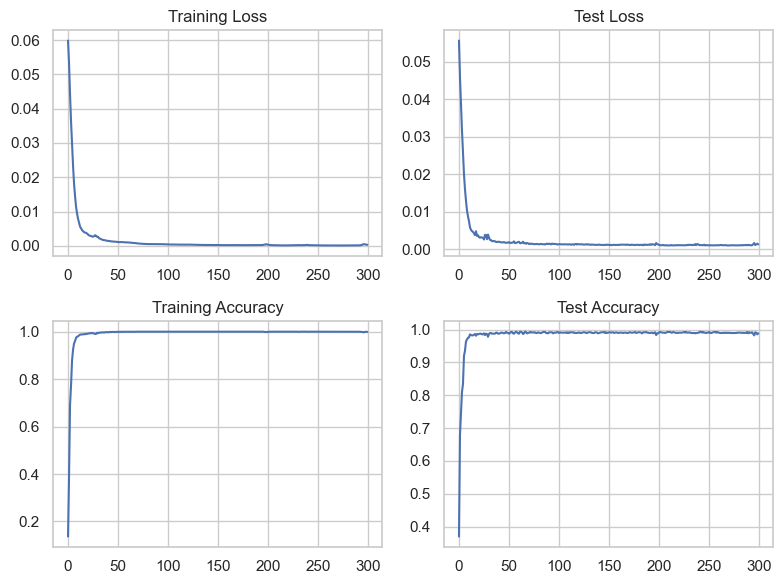

In [12]:
lr = 0.001
model, train_losses, train_accuracies, test_losses, test_accuracies = train(train_loader, learning_rate=lr, epochs=300)
plot_all_losses(train_losses, test_losses, train_accuracies, test_accuracies)